In [15]:
#!pip install deepface
#!pip install tf-keras
#!pip install scikit-learn
#!pip install matplotlib

In [13]:
import os
import shutil
from deepface import DeepFace
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import sys
import numpy as np
sys.path.append('aux_scripts.py')

i=0

Define the folder and image name

Action: race: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]  


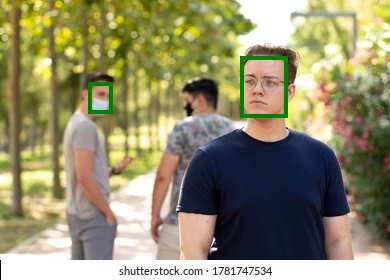

Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]  


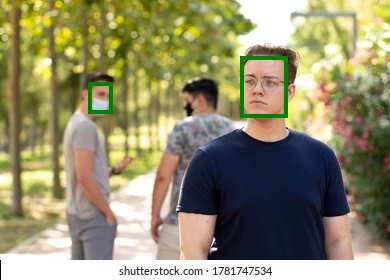

Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]  


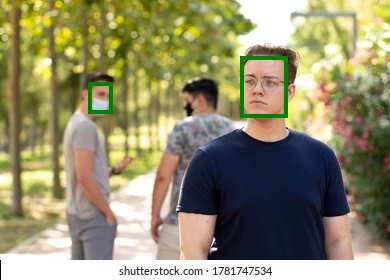

Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]  


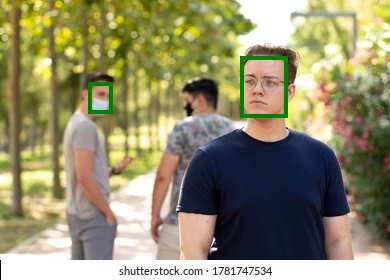

Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s]  


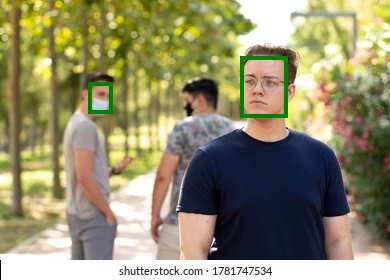

Action: race: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]  


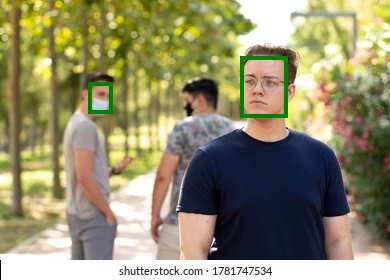

Action: race: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]  


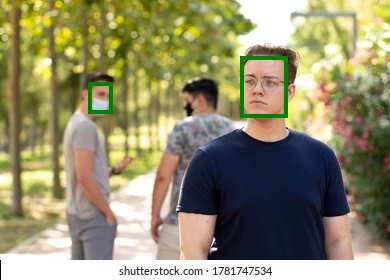

In [ ]:
folder_name = "../dataset/images/original/"
modified_folder_name = "../dataset/images/processed/"
cropped_folder_name = "../dataset/images/cropped/"

# Create the processed and cropped folders if they don't exist
os.makedirs(modified_folder_name, exist_ok=True)
os.makedirs(cropped_folder_name, exist_ok=True)

for image_name in os.listdir(folder_name):
    # Only process if the file is an image (e.g., PNG, JPG)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load image
        image_path = os.path.join(folder_name, image_name)
        image = Image.open(image_path)

        # Analyze the image
        analysis = DeepFace.analyze(img_path=image_path, detector_backend='retinaface', enforce_detection=False)
        
        # Draw bounding boxes for each face detected
        draw = ImageDraw.Draw(image)
        for idx, item in enumerate(analysis):
            region = item['region']
            x, y, w, h = region['x'], region['y'], region['w'], region['h']

            # Draw rectangle on the original image
            draw.rectangle([(x, y), (x + w, y + h)], outline='green', width=4)

            # Crop the detected face
            #cropped_face = image.crop((x, y, x + w, y + h))
            #cropped_face_path = os.path.join(cropped_folder_name, f"{image_name}_face_{idx + 1}.png")
            #cropped_face.save(cropped_face_path)
            #print(f"Cropped face saved as {cropped_face_path}")

        # Save the image with bounding boxes
        modified_image_path = os.path.join(modified_folder_name, "MOD_" + image_name)
        #image.save(modified_image_path)
        
        # Optionally, display the processed image
        modified_image = Image.open(modified_image_path)
        display(modified_image)


## NN creation and training

### Split the data into training and validation sets

In [8]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))
    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))

In [ ]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Reduce learning rate when validation loss plateaus
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks= [early_stopping,reduce_lr]   # Add the callbacks here
)

# Save the model after training
model.save('mask_detector_model.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


i+=1

# Save the model
model.save(f'mask_detector_model_{i}.h5')

# Print training summary
print("Model trained and saved as 'mask_detector_model.h5'")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 3274 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Found 409 images belonging to 2 classes.
Epoch 1/10
103/103 [==============================] - 65s 623ms/step - loss: 0.5031 - accuracy: 0.7581 - val_loss: 0.2777 - val_accuracy: 0.8851 - lr: 0.0010
Epoch 2/10
103/103 [==============================] - 61s 595ms/step - loss: 0.3692 - accuracy: 0.8543 - val_loss: 0.3100 - val_accuracy: 0.8655 - lr: 0.0010
Epoch 3/10
103/103 [==============================] - 70s 676ms/step - loss: 0.3384 - accuracy: 0.8662 - val_loss: 0.2104 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 4/10
103/103 [==============================] - 66s 644ms/step - loss: 0.3112 - accuracy: 0.8797 - val_loss: 0.2051 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 5/10
103/103 [==============================] - 66s 642ms/step - loss: 0.3067 - accuracy: 0.8797 - val_loss: 0.1895 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 6/10
103/103 [==============================] - 67s 645ms/step - loss: 0.2887 - 

### Test the model on the test set

Load the model

In [22]:
## load the model
n = 1
model = tf.keras.models.load_model(f'mask_detector_model_{n}.h5')

Test the model on the test set

1/1 [==============================] - 0s 210ms/step


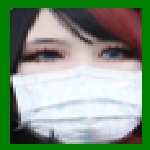

Image: mask6.png - Prediction: Mask (0.38)
1/1 [==============================] - 0s 35ms/step


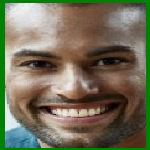

Image: no_mask4.png - Prediction: No Mask (0.86)
1/1 [==============================] - 0s 21ms/step


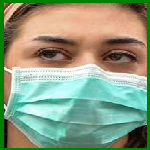

Image: mask1.png - Prediction: Mask (0.00)
1/1 [==============================] - 0s 25ms/step


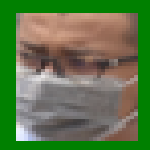

Image: mask0.png - Prediction: No Mask (0.97)
1/1 [==============================] - 0s 26ms/step


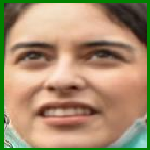

Image: wrong_mask.png - Prediction: No Mask (0.99)
1/1 [==============================] - 0s 21ms/step


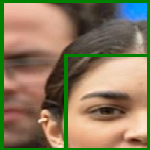

Image: no_mask2.png - Prediction: Mask (0.25)
1/1 [==============================] - 0s 22ms/step


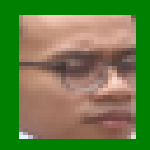

Image: no_mask0.png - Prediction: No Mask (1.00)
1/1 [==============================] - 0s 23ms/step


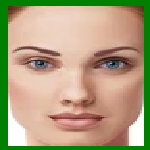

Image: no_mask5.png - Prediction: No Mask (1.00)
1/1 [==============================] - 0s 29ms/step


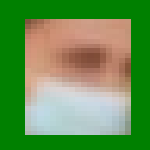

Image: mask3.png - Prediction: No Mask (0.99)
1/1 [==============================] - 0s 22ms/step


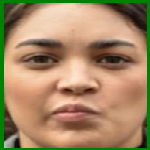

Image: no_mask1.png - Prediction: No Mask (0.99)
1/1 [==============================] - 0s 21ms/step


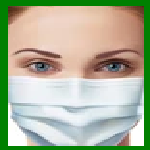

Image: mask2.png - Prediction: Mask (0.16)
1/1 [==============================] - 0s 22ms/step


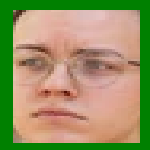

Image: no_mask6.png - Prediction: No Mask (1.00)
1/1 [==============================] - 0s 20ms/step


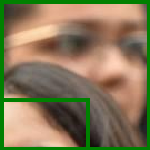

Image: no_mask3.png - Prediction: Mask (0.07)
1/1 [==============================] - 0s 23ms/step


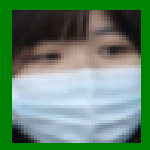

Image: mask5.png - Prediction: Mask (0.31)
1/1 [==============================] - 0s 44ms/step


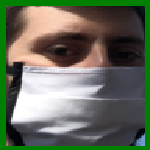

Image: mask4.png - Prediction: Mask (0.11)


In [14]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

# Function to make predictions on individual images
def predict_images(folder_path):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        # Load and preprocess the image
        img = load_img(image_path, target_size=(150, 150))  # Resize to match input size
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
        # Make prediction
        prediction = model.predict(img_array)
        label = "Mask" if prediction[0][0] < 0.5 else "No Mask"
        display(img)
        print(f"Image: {image_name} - Prediction: {label} ({prediction[0][0]:.2f})")

# Call the function
predict_images(test_images_folder)
